In [ ]:
import pandas as pd
import numpy as np
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel

# === Load data ===
merged_df = pd.read_csv("training/merged_df.csv")
features_to_label = pd.read_csv("features.csv")
features_to_label.rename(columns={'psi6/msd':'psi/msd'}, inplace=True)

# === Labeling constants ===
STABLE = 1
UNSTABLE = 0
ABSTAIN = -1

# === Compute thresholds from stable configs ===
stable_df = merged_df[merged_df["status"] == "stable"]
unwanted = ['config', 'status']
features = [col for col in merged_df.columns if col not in unwanted]

fixed_thresholds = {}
for feat in features:
    low = stable_df[feat].quantile(0.05)
    high = stable_df[feat].quantile(0.95)
    fixed_thresholds[feat] = (low, high)
    #print(low)

# === Labeling functions ===
def make_percentile_lf(feature, low, high):
    @labeling_function(name=f"lf_{feature}_percentile")
    def lf(x):
        val = x[feature]
        if pd.isna(val):
            return ABSTAIN
        return STABLE if low <= val <= high else UNSTABLE
    return lf

lfs = [make_percentile_lf(feat, *fixed_thresholds[feat]) for feat in features]

In [9]:
fixed_thresholds

{'msd': (np.float64(0.00020689859008544), np.float64(0.000582527971282)),
 'rdf': (np.float64(18.31646), np.float64(31.487779999999994)),
 'psi6': (np.float64(0.37072653206794076), np.float64(0.4941995748061643)),
 'rdf/msd': (np.float64(32026.940024157167), np.float64(135801.36816802842)),
 'psi/msd': (np.float64(658.2686962381362), np.float64(2378.769812283029)),
 'cn_at_1.5': (np.float64(10.045), np.float64(15.491679999999999)),
 'cn_slope': (np.float64(16.802403792209585), np.float64(29.261021985298708)),
 'cn_1.5/msd': (np.float64(17577.69815863569), np.float64(66194.56692263029)),
 'cn_slope/msd': (np.float64(31446.753560420468),
  np.float64(142069.65268061784))}

In [2]:
# === Apply labeling functions ===
applier = PandasLFApplier(lfs=lfs)
L = applier.apply(features_to_label)

100%|██████████| 256/256 [00:00<00:00, 31967.07it/s]


In [3]:
# === Analyze individual LF performance ===
print(LFAnalysis(L, lfs).lf_summary())

                            j Polarity  Coverage  Overlaps  Conflicts
lf_msd_percentile           0   [0, 1]       1.0       1.0   0.816406
lf_rdf_percentile           1   [0, 1]       1.0       1.0   0.816406
lf_psi6_percentile          2   [0, 1]       1.0       1.0   0.816406
lf_rdf/msd_percentile       3   [0, 1]       1.0       1.0   0.816406
lf_psi/msd_percentile       4   [0, 1]       1.0       1.0   0.816406
lf_cn_at_1.5_percentile     5   [0, 1]       1.0       1.0   0.816406
lf_cn_slope_percentile      6   [0, 1]       1.0       1.0   0.816406
lf_cn_1.5/msd_percentile    7   [0, 1]       1.0       1.0   0.816406
lf_cn_slope/msd_percentile  8   [0, 1]       1.0       1.0   0.816406


In [4]:
# === Train Snorkel LabelModel ===
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:01<00:00, 252.00epoch/s]
INFO:root:Finished Training


In [6]:
import pickle
with open("label_model.pkl","wb") as f:
    pickle.dump(label_model, f)


In [ ]:
test_features = pd.read_csv('test/transitions_features.csv')

In [141]:
test_features.rename(columns={"psi6/msd":"psi/msd"}, inplace=True)

In [137]:
features_to_label.columns

Index(['config', 'msd', 'rdf', 'psi6', 'cn_at_1.5', 'cn_slope', 'rdf/msd',
       'psi/msd', 'cn_1.5/msd', 'cn_slope/msd', 'predicted_label',
       'predicted_label_name'],
      dtype='object')

In [142]:
# Create test label matrix
L_test = applier.apply(test_features)

# Convert true labels
true_labels = test_features['status'].map({'unstable': 0, 'stable': 1}).values

# Predict and evaluate
preds_test = label_model.predict(L=L_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(true_labels, preds_test))
print("Precision:", precision_score(true_labels, preds_test))
print("Recall:", recall_score(true_labels, preds_test))
print("F1 Score:", f1_score(true_labels, preds_test))


100%|██████████| 25/25 [00:00<00:00, 8981.38it/s]

Accuracy: 0.92
Precision: 1.0
Recall: 0.75
F1 Score: 0.8571428571428571


In [143]:
test_features['predicted_status'] = preds_test
test_features

,config,msd,rdf,psi6,cn_at_1.5,cn_slope,rdf/msd,psi/msd,cn_1.5/msd,cn_slope/msd,status,predicted_status
0,config_1,0.001627,10.4103,0.360246,6.08680,4.953541,6.399640e+03,221.457839,3741.806635,3045.145669,unstable,0
1,config_2,0.001354,11.0856,0.361498,6.69980,5.666554,8.189162e+03,267.046056,4949.280865,4186.000873,unstable,0
2,config_3,0.001144,11.4771,0.360091,7.17485,6.301080,1.003124e+04,314.727358,6270.977333,5507.283436,unstable,0
3,config_4,0.000973,12.3051,0.363675,7.65305,6.992557,1.264396e+04,373.690573,7863.803648,7185.121339,unstable,0
4,config_5,0.000937,12.9772,0.371986,7.92705,7.574101,1.384506e+04,396.862309,8457.174804,8080.621887,unstable,0
5,config_6,0.000728,13.5761,0.376737,8.22255,8.192142,1.864962e+04,517.526858,11295.399001,11253.627196,unstable,0
6,config_7,0.000708,14.0093,0.378746,8.41190,8.542184,1.978381e+04,534.861252,11879.211761,12063.197783,unstable,0
7,config_8,0.000720,15.2838,0.392743,8.60150,9.184181,2.122690e+04,545.460753,11946.187941,12755.444001,unstable,0
8,config_9,0.000597,16.0183,0.393972,8.69960,9.815590,2.685375e+04,660.471860,14584.374447,16455.267107,stable,0
9,config_10,0.000613,16.6990,0.417145,8.95445,10.646310,2.724095e+04,680.484605,14607.323563,17367.241592,stable,0


In [75]:
# === Predict probabilistic and hard labels ===
probs = label_model.predict_proba(L)
preds = label_model.predict(L)

In [76]:
preds

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
probs

array([[2.97752582e-09, 9.99999997e-01],
       [9.97055158e-01, 2.94484195e-03],
       [4.72734951e-15, 1.00000000e+00],
       [9.14629845e-01, 8.53701553e-02],
       [9.93326386e-01, 6.67361441e-03],
       [9.99824812e-01, 1.75187552e-04],
       [9.14629845e-01, 8.53701553e-02],
       [9.99824812e-01, 1.75187552e-04],
       [1.77741864e-02, 9.82225814e-01],
       [2.07821933e-15, 1.00000000e+00],
       [9.97055158e-01, 2.94484195e-03],
       [9.90272307e-01, 9.72769280e-03],
       [9.98337880e-01, 1.66211999e-03],
       [9.98337880e-01, 1.66211999e-03],
       [8.38640237e-15, 1.00000000e+00],
       [2.07821933e-15, 1.00000000e+00],
       [9.14629845e-01, 8.53701553e-02],
       [9.14629845e-01, 8.53701553e-02],
       [2.07821933e-15, 1.00000000e+00],
       [7.89243145e-03, 9.92107569e-01],
       [9.14629845e-01, 8.53701553e-02],
       [9.93326386e-01, 6.67361441e-03],
       [9.14629845e-01, 8.53701553e-02],
       [9.60584247e-01, 3.94157533e-02],
       [9.970551

In [78]:
for feat, (low, high) in fixed_thresholds.items():
    print(f"{feat}: {low:.4f} – {high:.4f}")


msd: 0.0002 – 0.0006
rdf: 18.3165 – 31.4878
psi6: 0.3707 – 0.4942
rdf/msd: 32026.9400 – 135801.3682
psi/msd: 658.2687 – 2378.7698
cn_at_1.5: 10.0450 – 15.4917
cn_slope: 16.8024 – 29.2610
cn_1.5/msd: 17577.6982 – 66194.5669
cn_slope/msd: 31446.7536 – 142069.6527


In [79]:


# Add predictions to DataFrame
features_to_label["predicted_label"] = preds
features_to_label["predicted_label_name"] = features_to_label["predicted_label"].map({STABLE: "stable", UNSTABLE: "unstable"})

# Optional: concat with original sample metadata
X_train = pd.read_csv("parameter_samples.csv")
#df = pd.concat([df.reset_index(drop=True), features_to_label.reset_index(drop=True)], axis=1)

# LabelModel probs array: shape (N, 2)
# probs[i, 1] = P(STABLE)

y_train = pd.Series(preds)



In [ ]:
test = pd.read_csv("test/parameter_samples.csv")

In [89]:
y_test = merged_df['status']
X_test = test.loc[:,test.columns != 'status']
label_mapping = {'unstable': 0, 'stable': 1}
y_test = np.array([label_mapping[label] for label in y_test])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'C': 1, 'l1_ratio': 0.9}
Best Training ROC AUC (3-CV): 0.69
Test Accuracy: 0.73
Test ROC AUC: 0.39


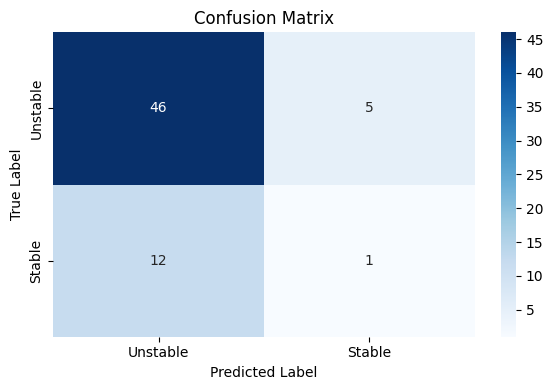

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Assuming X_train, y_train, X_test, and y_test are already defined.
# They should have numeric features and labels (0 for 'unstable', 1 for 'stable').

# Define the parameter grid for Elastic Net logistic regression.
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Instantiate logistic regression with elastic net penalty.
lr_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',      # 'saga' supports elastic net penalty.
    max_iter=10000,
    random_state=42
)

# Set up GridSearchCV with 3-fold cross-validation.
grid = GridSearchCV(
    estimator=lr_elastic,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the training data.
grid.fit(X_train, y_train)

# Report the best hyperparameters and best CV ROC AUC.
print("Best Hyperparameters:", grid.best_params_)
print("Best Training ROC AUC (3-CV): {:.2f}".format(grid.best_score_))

# Use the best estimator from grid search to predict on the test set.
best_model = grid.best_estimator_

# Obtain predicted probabilities and hard predictions.
y_test_pred_probs = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

# Calculate performance metrics on the test set.
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}")

# Compute the confusion matrix.
cm = confusion_matrix(y_test, y_test_pred)


# Plot the confusion matrix using seaborn for better visualization.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


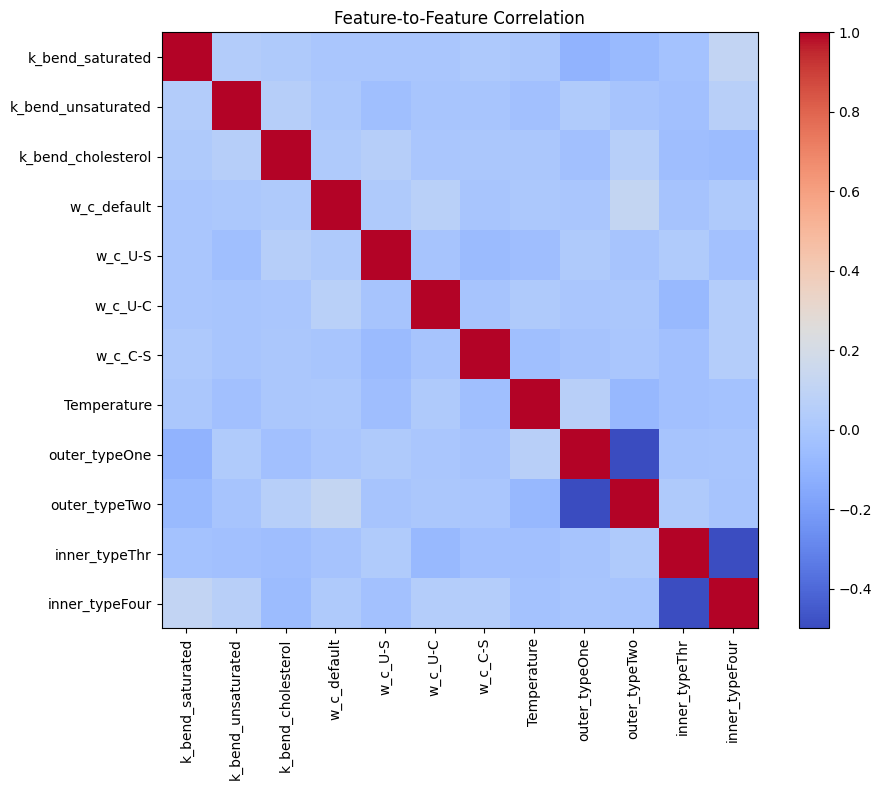

Correlation of features with soft_label:
hard_label            1.000000
soft_label            1.000000
Temperature           0.231554
outer_typeOne         0.040399
k_bend_saturated      0.026750
w_c_C-S               0.008769
w_c_U-C               0.007598
inner_typeThr        -0.004280
inner_typeFour       -0.029290
k_bend_unsaturated   -0.035877
k_bend_cholesterol   -0.048295
outer_typeTwo        -0.098177
w_c_default          -0.184959
w_c_U-S              -0.219991
Name: soft_label, dtype: float64 

Correlation of features with hard_label:
hard_label            1.000000
soft_label            1.000000
Temperature           0.231554
outer_typeOne         0.040399
k_bend_saturated      0.026750
w_c_C-S               0.008769
w_c_U-C               0.007598
inner_typeThr        -0.004280
inner_typeFour       -0.029290
k_bend_unsaturated   -0.035877
k_bend_cholesterol   -0.048295
outer_typeTwo        -0.098177
w_c_default          -0.184959
w_c_U-S              -0.219991
Name: hard_labe

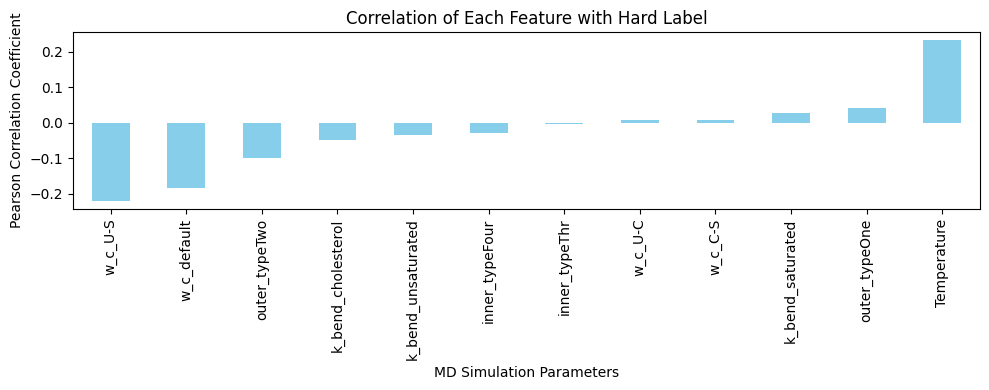

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose:
#  - X_train is a DataFrame with all numeric MD simulation parameters.
#  - y_train is an array-like of probabilities (soft labels) for 'stable'.
#
# For correlation analysis with the labels, it is useful to have:
#  a. The original probabilities (soft labels).
#  b. Hard labels (binary), thresholded at 0.5, for a simple classification perspective.

# Convert y_train to a NumPy array (if needed)
y_train = np.array(y_train)

# Create hard labels with a 0.5 threshold:
y_train_hard = (y_train >= 0.5).astype(int)

# --------------------------------------------
# 1. Correlation Among Features
# --------------------------------------------

# Compute the correlation matrix of the features in X_train
feature_corr = X_train.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(feature_corr, cmap='coolwarm', interpolation='nearest')
plt.title('Feature-to-Feature Correlation')
plt.colorbar()
plt.xticks(range(len(feature_corr.columns)), feature_corr.columns, rotation=90)
plt.yticks(range(len(feature_corr.columns)), feature_corr.columns)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. Correlation Between Features and Labels
# --------------------------------------------

# Create a copy of X_train to add the label(s) for correlation analysis.
df_corr = X_train.copy()

# Add the soft and hard labels as new columns
df_corr['soft_label'] = y_train
df_corr['hard_label'] = y_train_hard

# Compute the correlation matrix including the labels
full_corr = df_corr.corr()

# Print the correlations of each feature with the labels
print("Correlation of features with soft_label:")
print(full_corr['soft_label'].sort_values(ascending=False), "\n")

print("Correlation of features with hard_label:")
print(full_corr['hard_label'].sort_values(ascending=False), "\n")

# Optionally, visualize the correlation between features and one of the label columns
# Here we create a bar plot for the correlation with the hard label.
plt.figure(figsize=(10, 4))
hard_corr = full_corr['hard_label'].drop(['soft_label', 'hard_label'])
hard_corr.sort_values(inplace=True)
hard_corr.plot(kind='bar', color='skyblue')
plt.title('Correlation of Each Feature with Hard Label')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('MD Simulation Parameters')
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters (XGBoost): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1.0}
Best Training ROC AUC (3-CV): 0.75
XGBoost Test Accuracy: 0.80
XGBoost Test ROC AUC: 0.47


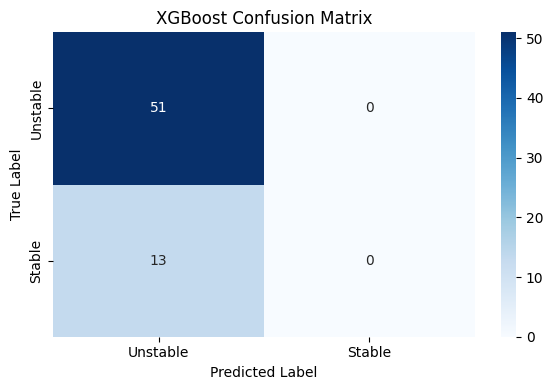

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb

# Assuming X_train, y_train, X_test, and y_test are already defined.
# Labels should be numeric (0 for 'unstable', 1 for 'stable').

# Define a parameter grid with regularization parameters included.
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1.0],
    'reg_alpha': [0, 0.1, 1],    # L1 regularization
    'reg_lambda': [1, 10]        # L2 regularization
}

# Instantiate the XGBoost classifier.
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',  # Evaluation metric for CV
    use_label_encoder=False,
    random_state=42
)

# Set up GridSearchCV with 3-fold cross-validation.
grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the training data.
grid_xgb.fit(X_train, y_train)

# Report the best hyperparameters and best training (CV) ROC AUC.
print("Best Hyperparameters (XGBoost):", grid_xgb.best_params_)
print("Best Training ROC AUC (3-CV): {:.2f}".format(grid_xgb.best_score_))

# Use the best estimator to predict on the test set.
best_xgb = grid_xgb.best_estimator_

# Obtain predicted probabilities and hard predictions.
y_test_pred_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred_xgb = best_xgb.predict(X_test)

# Calculate performance metrics on the test set.
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_pred_probs_xgb)

print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")
print(f"XGBoost Test ROC AUC: {test_roc_auc_xgb:.2f}")

# Compute the confusion matrix.
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.show()


Before SMOTE - Class distribution in y_train: {np.int64(0): np.int64(190), np.int64(1): np.int64(66)}
After SMOTE - Class distribution in y_train_res: {np.int64(0): np.int64(190), np.int64(1): np.int64(190)}
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "colsample_by", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "colsample_by", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "colsample_by", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "colsample_by", "use_label_encode

Best Hyperparameters (XGBoost with SMOTE): {'colsample_by': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best Training ROC AUC (3-CV): 0.94
XGBoost with SMOTE Test Accuracy: 0.67
XGBoost with SMOTE Test ROC AUC: 0.47

Confusion Matrix:
[[38 13]
 [ 8  5]]


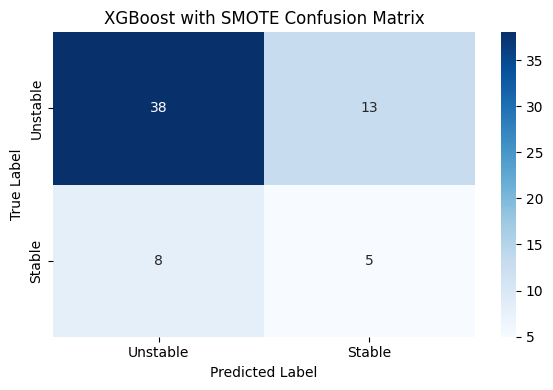

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import xgboost as xgb
from imblearn.over_sampling import SMOTE

# ---------------------------
# 1. Oversample the Minority Class
# ---------------------------
# Assuming X_train, y_train, X_test, and y_test are already defined,
# and that labels are numeric (e.g., 0 for 'unstable' and 1 for 'stable').

# Check class distribution before oversampling
unique, counts = np.unique(y_train, return_counts=True)
print("Before SMOTE - Class distribution in y_train:", dict(zip(unique, counts)))

# Use SMOTE to oversample the minority class in your training data.
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("After SMOTE - Class distribution in y_train_res:", dict(zip(unique_res, counts_res)))

# ---------------------------
# 2. Grid Search with XGBoost on the Oversampled Data
# ---------------------------
# Define a hyperparameter grid for XGBoost including some regularization parameters.
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.4, 0.8],
    'colsample_by': [0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],    # L1 regularization term
    'reg_lambda': [1, 10]        # L2 regularization term
}

# Instantiate the XGBoost classifier.
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Set up GridSearchCV (3-fold cross-validation on the oversampled data).
grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit grid search on the oversampled training data.
grid_xgb.fit(X_train_res, y_train_res)

# Report the best hyperparameters and best training (CV) ROC AUC.
print("Best Hyperparameters (XGBoost with SMOTE):", grid_xgb.best_params_)
print("Best Training ROC AUC (3-CV): {:.2f}".format(grid_xgb.best_score_))

# ---------------------------
# 3. Evaluate the Model on the Original Test Set
# ---------------------------
best_xgb = grid_xgb.best_estimator_

# Predict probabilities and hard labels on the test set.
y_test_pred_probs = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred = best_xgb.predict(X_test)

# Calculate performance metrics on the test set.
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"XGBoost with SMOTE Test Accuracy: {test_accuracy:.2f}")
print(f"XGBoost with SMOTE Test ROC AUC: {test_roc_auc:.2f}")

# ---------------------------
# 4. Plot and Print the Confusion Matrix (Diffusion Matrix)
# ---------------------------
cm = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix (text version)
print("\nConfusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn for better visualization.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost with SMOTE Confusion Matrix')
plt.tight_layout()
plt.show()


[0]	train-auc:0.80107	eval-auc:0.76108
[1]	train-auc:0.88887	eval-auc:0.80229
[2]	train-auc:0.92661	eval-auc:0.85249
[3]	train-auc:0.92785	eval-auc:0.84695
[4]	train-auc:0.93360	eval-auc:0.86150
[5]	train-auc:0.94300	eval-auc:0.86981
[6]	train-auc:0.94813	eval-auc:0.86946
[7]	train-auc:0.95771	eval-auc:0.86738
[8]	train-auc:0.95938	eval-auc:0.86946
[9]	train-auc:0.96356	eval-auc:0.86634
[10]	train-auc:0.96498	eval-auc:0.86150
[11]	train-auc:0.96150	eval-auc:0.86011
[12]	train-auc:0.96689	eval-auc:0.86046
[13]	train-auc:0.97299	eval-auc:0.85907
[14]	train-auc:0.97745	eval-auc:0.85873
[15]	train-auc:0.98052	eval-auc:0.86496
[16]	train-auc:0.98420	eval-auc:0.86773
[17]	train-auc:0.98624	eval-auc:0.87050
[18]	train-auc:0.98966	eval-auc:0.86704
[19]	train-auc:0.99173	eval-auc:0.86773
[20]	train-auc:0.99329	eval-auc:0.85942
[21]	train-auc:0.99403	eval-auc:0.86565
[22]	train-auc:0.99511	eval-auc:0.86634
[23]	train-auc:0.99619	eval-auc:0.86427
[24]	train-auc:0.99688	eval-auc:0.86773
[25]	train

[34]	train-auc:0.99983	eval-auc:0.87258
[35]	train-auc:0.99987	eval-auc:0.86981
[36]	train-auc:1.00000	eval-auc:0.87050
[37]	train-auc:1.00000	eval-auc:0.86496
[38]	train-auc:1.00000	eval-auc:0.87050
[39]	train-auc:1.00000	eval-auc:0.87188
[40]	train-auc:1.00000	eval-auc:0.87742
[41]	train-auc:1.00000	eval-auc:0.87604
[42]	train-auc:1.00000	eval-auc:0.87812
[43]	train-auc:1.00000	eval-auc:0.87742
[44]	train-auc:1.00000	eval-auc:0.87881


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [18:10:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[45]	train-auc:1.00000	eval-auc:0.88019
[46]	train-auc:1.00000	eval-auc:0.88435
[47]	train-auc:1.00000	eval-auc:0.88366
[48]	train-auc:1.00000	eval-auc:0.88504
[49]	train-auc:1.00000	eval-auc:0.88504
[50]	train-auc:1.00000	eval-auc:0.88366
[51]	train-auc:1.00000	eval-auc:0.88504
[52]	train-auc:1.00000	eval-auc:0.88989
[53]	train-auc:1.00000	eval-auc:0.88989
[54]	train-auc:1.00000	eval-auc:0.88989
[55]	train-auc:1.00000	eval-auc:0.88781
[56]	train-auc:1.00000	eval-auc:0.89058
[57]	train-auc:1.00000	eval-auc:0.88989
[58]	train-auc:1.00000	eval-auc:0.89404
[59]	train-auc:1.00000	eval-auc:0.89543
[60]	train-auc:1.00000	eval-auc:0.89474
[61]	train-auc:1.00000	eval-auc:0.89266
[62]	train-auc:1.00000	eval-auc:0.89404
[63]	train-auc:1.00000	eval-auc:0.89543
[64]	train-auc:1.00000	eval-auc:0.89474
[65]	train-auc:1.00000	eval-auc:0.89335
[66]	train-auc:1.00000	eval-auc:0.89543
[67]	train-auc:1.00000	eval-auc:0.89197
[68]	train-auc:1.00000	eval-auc:0.88850
[69]	train-auc:1.00000	eval-auc:0.88920


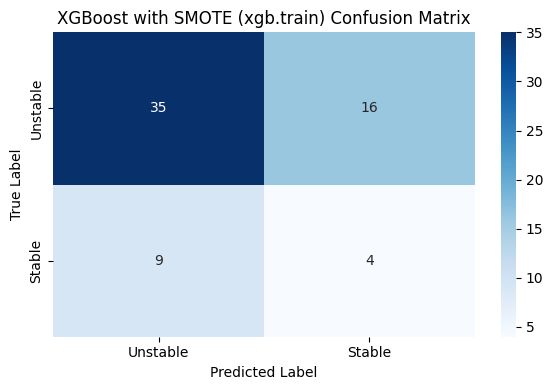

In [123]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare DMatrix ---
# Use the oversampled training split for training and validation.
dtrain = xgb.DMatrix(X_train_res_train, label=y_train_res_train)
dval = xgb.DMatrix(X_train_res_val, label=y_train_res_val)
dtest = xgb.DMatrix(X_test)

# --- Set Parameters ---
# Retrieve the best parameters from your grid search.
# (Ensure that the parameters are in the dictionary format expected by xgb.train.)
params = grid_xgb.best_estimator_.get_xgb_params()
# XGBClassifier.get_xgb_params() returns parameters used by xgb.train,
# but you might need to add the evaluation metric if it's missing.
params['eval_metric'] = 'auc'
params['objective'] = 'binary:logistic'

# Determine the number of boosting rounds; you can use the n_estimators from your grid.
num_boost_round = grid_xgb.best_params_.get('n_estimators', 200)

# Create a watchlist to enable early stopping.
watchlist = [(dtrain, 'train'), (dval, 'eval')]

# --- Train with Early Stopping ---
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=30,
    verbose_eval=True
)

# --- Evaluate on the Test Set ---
# Get predicted probabilities
y_test_pred_probs = bst.predict(dtest)
# Convert predicted probabilities to binary class labels (threshold = 0.5)
y_test_pred = (y_test_pred_probs >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"XGBoost with SMOTE (Early Stopping via xgb.train) Test Accuracy: {test_accuracy:.2f}")
print(f"XGBoost with SMOTE (Early Stopping via xgb.train) Test ROC AUC: {test_roc_auc:.2f}")

# --- Plot the Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost with SMOTE (xgb.train) Confusion Matrix')
plt.tight_layout()
plt.show()


Before SMOTE - Class distribution in y_train: {np.int64(0): np.int64(190), np.int64(1): np.int64(66)}
After SMOTE - Class distribution in y_train_res: {np.int64(0): np.int64(190), np.int64(1): np.int64(190)}
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:23:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:23:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:23:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:23:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters (XGBoost with SMOTE): {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best Training ROC AUC (3-CV): 0.94
[0]	train-auc:0.91259	train-error:0.14474	eval-auc:0.83518	eval-error:0.19737
[1]	train-auc:0.95709	train-error:0.10526	eval-auc:0.85665	eval-error:0.18421
[2]	train-auc:0.97745	train-error:0.07895	eval-auc:0.85353	eval-error:0.19737
[3]	train-auc:0.97877	train-error:0.08553	eval-auc:0.86184	eval-error:0.17105
[4]	train-auc:0.98284	train-error:0.07895	eval-auc:0.86911	eval-error:0.15789
[5]	train-auc:0.98288	train-error:0.07237	eval-auc:0.87708	eval-error:0.18421
[6]	train-auc:0.98810	train-error:0.05263	eval-auc:0.88885	eval-error:0.19737
[7]	train-auc:0.99225	train-error:0.04605	eval-auc:0.89197	eval-error:0.15789
[8]	train-auc:0.99628	train-error:0.03289	eval-auc:0.89543	eval-error:0.17105
[9]	train-auc:0.99727	train-error:0.02961	eval-auc:0.90305	eval-error:0.14474
[10]	t

/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [18:24:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


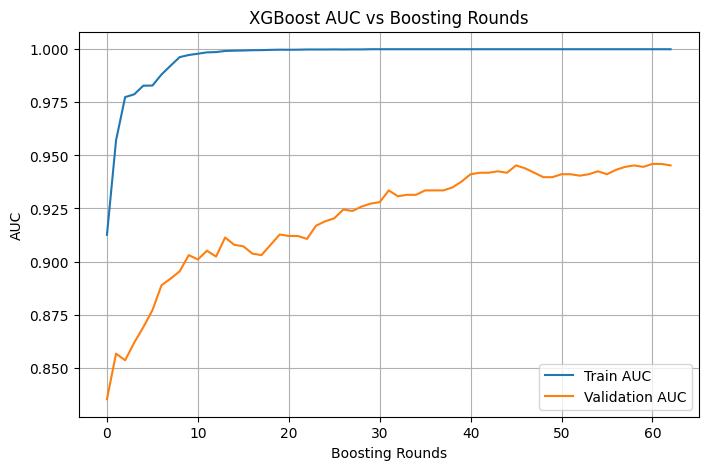

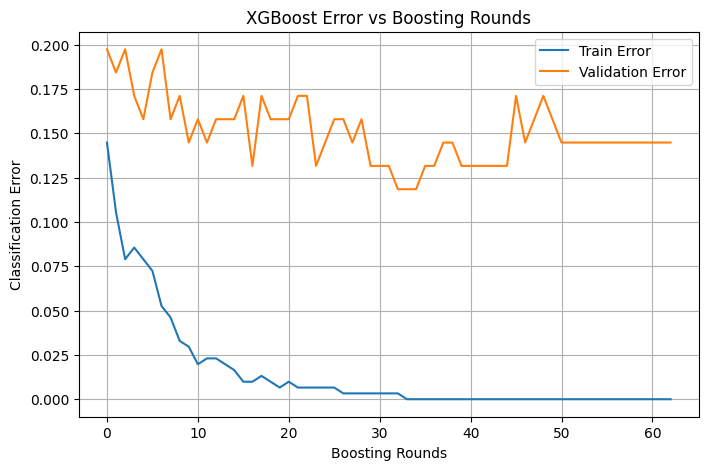

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

import xgboost as xgb

# ===============================================================
# 1. Prepare your data (Assumed pre-defined: X_train, y_train, X_test, y_test)
# ===============================================================
# For example: Uncomment and adjust if you need to load or generate your data.
# X_train = pd.read_csv('X_train.csv')
# y_train = pd.read_csv('y_train.csv').values.ravel()
# X_test  = pd.read_csv('X_test.csv')
# y_test  = pd.read_csv('y_test.csv').values.ravel()

# ===============================================================
# 2. Oversample the Minority Class using SMOTE
# ===============================================================
print("Before SMOTE - Class distribution in y_train:", dict(zip(*np.unique(y_train, return_counts=True))))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE - Class distribution in y_train_res:", dict(zip(*np.unique(y_train_res, return_counts=True))))

# ===============================================================
# 3. Grid Search Over the Specified Parameter Grid Using XGBClassifier
# ===============================================================
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.4, 0.8],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],    # L1 regularization
    'reg_lambda': [1, 10]        # L2 regularization
}

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Run grid search on the oversampled training data
grid_xgb.fit(X_train_res, y_train_res)

print("Best Hyperparameters (XGBoost with SMOTE):", grid_xgb.best_params_)
print("Best Training ROC AUC (3-CV): {:.2f}".format(grid_xgb.best_score_))

# ===============================================================
# 4. Retrain Best Model with Early Stopping Using xgb.train and Capture Training History
# ===============================================================
# Split the oversampled data into training and validation sets for early stopping.
X_train_res_train, X_train_res_val, y_train_res_train, y_train_res_val = train_test_split(
    X_train_res, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
)

# Convert training and validation splits into DMatrix objects.
dtrain = xgb.DMatrix(X_train_res_train, label=y_train_res_train)
dval   = xgb.DMatrix(X_train_res_val,   label=y_train_res_val)
dtest  = xgb.DMatrix(X_test)

# Retrieve the best parameters from grid search.
# Note: XGBClassifier.get_xgb_params() returns parameters in a dictionary format.
params = grid_xgb.best_estimator_.get_xgb_params()
params['objective'] = 'binary:logistic'
# We will track both AUC and classification error.
params['eval_metric'] = ['auc', 'error']

# Use the best n_estimators from grid search (or a default value if not present)
num_boost_round = grid_xgb.best_params_.get('n_estimators', 200)

# Create a watchlist to monitor training and validation performance.
watchlist = [(dtrain, 'train'), (dval, 'eval')]

# Dictionary to store evaluation results at each boosting round.
evals_result = {}

# Train with early stopping.
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=True
)

# ===============================================================
# 5. Plot Training/Validation Curves
# ===============================================================
epochs = len(evals_result['train']['auc'])
x_axis = range(epochs)

# Plot AUC curves
plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result['train']['auc'], label='Train AUC')
plt.plot(x_axis, evals_result['eval']['auc'], label='Validation AUC')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.title('XGBoost AUC vs Boosting Rounds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot classification error curves
plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result['train']['error'], label='Train Error')
plt.plot(x_axis, evals_result['eval']['error'], label='Validation Error')
plt.xlabel('Boosting Rounds')
plt.ylabel('Classification Error')
plt.title('XGBoost Error vs Boosting Rounds')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



XGBoost with SMOTE (Early Stopping via xgb.train) Test Accuracy: 0.58
XGBoost with SMOTE (Early Stopping via xgb.train) Test ROC AUC: 0.48


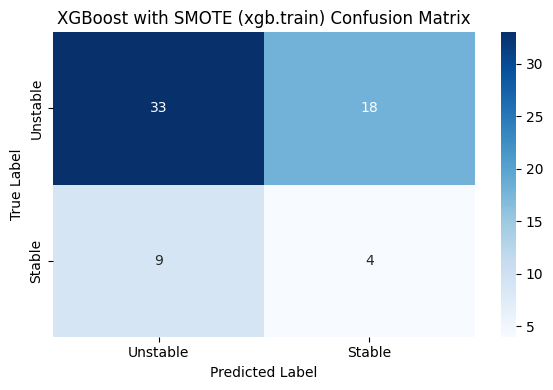

In [132]:
# ===============================================================
# 6. Evaluate the Model on the Test Set
# ===============================================================
# Use iteration_range with best_iteration if available.
if hasattr(bst, 'best_iteration'):
    # best_iteration is zero-indexed, so add 1 to include that round.
    y_test_pred_probs = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
else:
    y_test_pred_probs = bst.predict(dtest)

y_test_pred = (y_test_pred_probs >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"XGBoost with SMOTE (Early Stopping via xgb.train) Test Accuracy: {test_accuracy:.2f}")
print(f"XGBoost with SMOTE (Early Stopping via xgb.train) Test ROC AUC: {test_roc_auc:.2f}")

# ===============================================================
# 7. Plot the Confusion Matrix
# ===============================================================
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost with SMOTE (xgb.train) Confusion Matrix')
plt.tight_layout()
plt.show()

In [127]:
X_train.columns

Index(['k_bend_saturated', 'k_bend_unsaturated', 'k_bend_cholesterol',
       'w_c_default', 'w_c_U-S', 'w_c_U-C', 'w_c_C-S', 'Temperature',
       'outer_typeOne', 'outer_typeTwo', 'inner_typeThr', 'inner_typeFour'],
      dtype='object')

After SMOTE - Class distribution in y_train_res: {np.int64(0): np.int64(190), np.int64(1): np.int64(190)}
Random Forest Test Accuracy: 0.64
Random Forest Test ROC AUC: 0.40


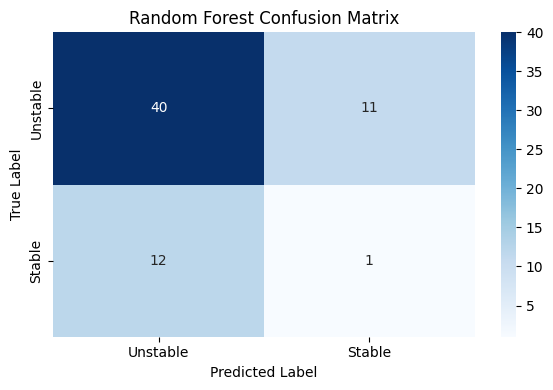

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# ---------------------------
# 1. Load your data
# ---------------------------
# Example placeholder – replace these with your actual data loading code.
# For instance, if your data comes from CSVs:
# X_train = pd.read_csv('X_train.csv')
# y_train = pd.read_csv('y_train.csv').values.ravel()
# X_test = pd.read_csv('X_test.csv')
# y_test = pd.read_csv('y_test.csv').values.ravel()

# Here, we assume that X_train and X_test are pandas DataFrames with at least the following columns:
# ['k_bend_saturated', 'k_bend_unsaturated', 'k_bend_cholesterol',
#  'w_c_default', 'w_c_U-S', 'w_c_U-C', 'w_c_C-S', 'Temperature',
#  'outer_typeOne', 'outer_typeTwo', 'inner_typeThr', 'inner_typeFour']

# ---------------------------
# 2. Feature Engineering
# ---------------------------
# Create new features based on the existing ones.

# a) k_bend features: total, ratio and difference
X_train['k_bend_total'] = (X_train['k_bend_saturated'] +
                           X_train['k_bend_unsaturated'] +
                           X_train['k_bend_cholesterol'])
X_test['k_bend_total'] = (X_test['k_bend_saturated'] +
                          X_test['k_bend_unsaturated'] +
                          X_test['k_bend_cholesterol'])

X_train['ratio_k_bend_sat_unsat'] = X_train['k_bend_saturated'] / (X_train['k_bend_unsaturated'] + 1e-6)
X_test['ratio_k_bend_sat_unsat'] = X_test['k_bend_saturated'] / (X_test['k_bend_unsaturated'] + 1e-6)

X_train['diff_k_bend_sat_unsat'] = X_train['k_bend_saturated'] - X_train['k_bend_unsaturated']
X_test['diff_k_bend_sat_unsat'] = X_test['k_bend_saturated'] - X_test['k_bend_unsaturated']

X_train['average_k_bend'] = X_train['k_bend_total'] / 3
X_test['average_k_bend'] = X_test['k_bend_total'] / 3

# b) w_c features: total and a ratio
X_train['w_c_total'] = (X_train['w_c_default'] +
                        X_train['w_c_U-S'] +
                        X_train['w_c_U-C'] +
                        X_train['w_c_C-S'])
X_test['w_c_total'] = (X_test['w_c_default'] +
                       X_test['w_c_U-S'] +
                       X_test['w_c_U-C'] +
                       X_test['w_c_C-S'])

X_train['ratio_U-S_to_default'] = X_train['w_c_U-S'] / (X_train['w_c_default'] + 1e-6)
X_test['ratio_U-S_to_default'] = X_test['w_c_U-S'] / (X_test['w_c_default'] + 1e-6)

# c) Interaction: Temperature and k_bend_total
X_train['temp_kbend_interaction'] = X_train['Temperature'] * X_train['k_bend_total']
X_test['temp_kbend_interaction'] = X_test['Temperature'] * X_test['k_bend_total']

# d) Outer and inner type features: sums, interactions, and ratio
X_train['outer_total'] = X_train['outer_typeOne'] + X_train['outer_typeTwo']
X_test['outer_total'] = X_test['outer_typeOne'] + X_test['outer_typeTwo']

X_train['inner_total'] = X_train['inner_typeThr'] + X_train['inner_typeFour']
X_test['inner_total'] = X_test['inner_typeThr'] + X_test['inner_typeFour']

X_train['outer_inner_interaction'] = X_train['outer_total'] * X_train['inner_total']
X_test['outer_inner_interaction'] = X_test['outer_total'] * X_test['inner_total']

X_train['outer_inner_ratio'] = X_train['outer_total'] / (X_train['inner_total'] + 1e-6)
X_test['outer_inner_ratio'] = X_test['outer_total'] / (X_test['inner_total'] + 1e-6)

# Optionally, you can create additional polynomial or interaction features as required.
# For example, a quadratic feature of Temperature:
X_train['Temperature_squared'] = X_train['Temperature'] ** 2
X_test['Temperature_squared'] = X_test['Temperature'] ** 2

# ---------------------------
# 3. (Optional) Oversample if Needed
# ---------------------------
# If you have class imbalance, you may want to oversample the minority class.
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE - Class distribution in y_train_res:", 
      dict(zip(*np.unique(y_train_res, return_counts=True))))

# ---------------------------
# 4. Train a Random Forest Classifier
# ---------------------------
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_train_res, y_train_res)
y_test_pred = rf.predict(X_test)
y_test_pred_probs = rf.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_test_pred)
rf_roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print("Random Forest Test Accuracy: {:.2f}".format(rf_accuracy))
print("Random Forest Test ROC AUC: {:.2f}".format(rf_roc_auc))

# ---------------------------
# 5. Plot the Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()


Feature Importances:
                    Feature  Importance
16                w_c_total    0.111190
3               w_c_default    0.094990
7               Temperature    0.068326
4                   w_c_U-S    0.062873
23      Temperature_squared    0.060885
18   temp_kbend_interaction    0.042704
17     ratio_U-S_to_default    0.042570
21  outer_inner_interaction    0.041299
20              inner_total    0.040071
5                   w_c_U-C    0.031855
9             outer_typeTwo    0.031653
1        k_bend_unsaturated    0.031052
2        k_bend_cholesterol    0.030912
19              outer_total    0.030472
10            inner_typeThr    0.030308
12             k_bend_total    0.030178
13   ratio_k_bend_sat_unsat    0.029819
0          k_bend_saturated    0.029330
14    diff_k_bend_sat_unsat    0.028459
6                   w_c_C-S    0.028093
22        outer_inner_ratio    0.027150
8             outer_typeOne    0.025978
15           average_k_bend    0.025718
11           inner_

/tmp/ipykernel_784371/1594098976.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


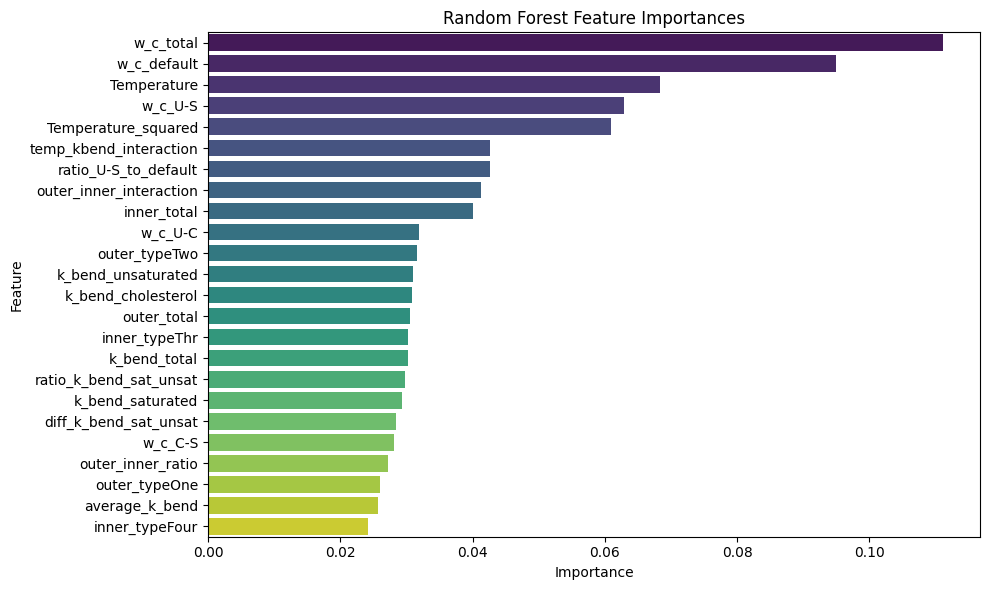

In [130]:
# ---------------------------
# 5. Compute and Plot Feature Importances
# ---------------------------
# Get feature importance scores from the random forest model.
importances = rf.feature_importances_
features = X_train.columns  # all current feature columns, including the new ones
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort in descending order.
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

# Plotting the feature importances.
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()